<a href="https://colab.research.google.com/github/k3larra/XAI-F/blob/main/Code_More_Sanity_Checks_for_Saliency_Maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#More Sanity Checks for Saliency Maps
This code accompanies the paper https://doi.org/XXXXX

Two zipfiles one containing the three images used and one contains the textfiles for the human saliency maps.

Five on ImageNet1k pretrained models are downloaded.
Using the visual explanation method Occlusion these methods are compared for similiarities and differences.
The study participants saliency maps are also compared for similarities and differences.

A final comparison is then made between humans and machine saliency maps, the more red the more disagreement on that a square is important for the comparison.



In [ ]:
#Cleaning if needed
! rm -r ISMIS 
! rm -r XAI-F
! rm -r testshapes2
! rm -r human_saliency
! rm imagenet_classes.txt

# Setup

In [ ]:
#Install XAI methods from captum.ai
%%capture
! pip install captum

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
import os
import sys
import urllib
import json
import random
from io import StringIO ##For images
from io import BytesIO
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
from torchvision import models
from torchvision import transforms
from torchvision.transforms import functional as transformsF
from captum.attr import IntegratedGradients
#from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import GuidedGradCam
from captum.attr import LayerGradCam
from captum.attr import LayerAttribution
from captum.attr import GradientShap
from captum.attr import Lime
from captum.attr import visualization as viz
#Extras for this test
import matplotlib.pyplot as plt
print(torch.__version__)
from zipfile import ZipFile
from random import randint
from torch.utils.data import Dataset
from torchvision import datasets

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import time
import os
import copy
import warnings
warnings.filterwarnings('ignore')

1.11.0+cu113


# Load test images and pretrained models 

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
#Get the images (In subfolder study 1) and the human_saliency maps for the different images 
#0=neither sufficient or nessesary, 1=not sufficient on its own, 1=sufficient on its own for classification
! git clone https://github.com/k3larra/XAI-F
with ZipFile('/content/XAI-F/testset2.zip', 'r') as archive:
  archive.extractall('/content/testshapes2')
with ZipFile('/content/XAI-F/human_saliency.zip', 'r') as archive:
  archive.extractall('/content/')

Cloning into 'XAI-F'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 57 (delta 18), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (57/57), done.


In [ ]:
#Get ImageNet1k class names
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
num_classes = len(categories)

def label_to_idx(label):
  return categories.index(label)

def idx_to_label(idx):
  #position = val_list.index(idx)
  return categories[idx]

--2022-06-15 13:58:04--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2022-06-15 13:58:04 (81.3 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



In [ ]:
#Download the five pretrained models used in the study
%%capture
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.hub._validate_not_a_forked_repo=lambda a,b,c: True #Skum grej från https://github.com/pytorch/pytorch/issues/61755
model_resnet101 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
model_resnet101.eval()
model_resnet101 = model_resnet101.to(device)
model_resnet152 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
model_resnet152.eval()
model_resnet152 = model_resnet152.to(device)
model_googlenet = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
model_googlenet.eval()
model_googlenet = model_googlenet.to(device)
model_inception_v3 = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
model_inception_v3.eval()
model_inception_v3 = model_inception_v3.to(device)
model_efficientnet_b4 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
model_efficientnet_b4.eval()
model_efficientnet_b4 =  model_efficientnet_b4.to(device)

# XAI Methods - Captum


In [ ]:
def show_image(image, prediction):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.title(prediction)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
from skimage import io, transform
from PIL import Image

eval_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        #transforms.CenterCrop(224),
        transforms.ToTensor()
    ])
transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

def transform_eval_data(img_path, eval_transform = None):
  image = Image.open(img_path).convert('RGB')
  
  if eval_transform:
      image = eval_transform(image)
      image = transform_normalize(image) #LH added for Imagenet
  image = image.float()
  return image
        

## Methods


In [ ]:
def calculate_occlusion(experiment_model, target_label, input_img, top_candidates, top_probs, img_index,  save_path="", save=False):
  experiment_model = experiment_model.to(device)
  input_img = input_img.to(device)
  occlusion = Occlusion(experiment_model)
  attributions = occlusion.attribute(input_img, 
                                       target=target_label,
                                       strides=(3, 32, 32),
                                       sliding_window_shapes=(3, 32, 32),
                                       baselines=0)
  input_img = input_img.squeeze()
  if save:
    n=str(img_index)
  #print(target_label, idx_to_label(top_candidates[0]), np.round(top_probs[0].item(),2))
  return attributions

# Helpers


In [ ]:
def eval_model(experiment_set, test_model, print_eval=False):
  since = time.time()
  test_model.eval()   # Set model to evaluate mode

  for experiment_sample in experiment_set:
    torch.set_printoptions(sci_mode=False)

    with torch.no_grad():
      input = experiment_sample
      input = torch.unsqueeze(input, 0)
      input = input.to(device)
      output = test_model(input)
      _, pred = torch.max(output, 1)

      input= input.cpu().squeeze()
      smax = F.softmax(output,dim=1)
      #print("prediction: ", pred, ", label: ", idx_to_label(pred))

      if print_eval:
        show_image(input.permute(1,2,0), idx_to_label(pred))
        print(smax)
        print("---------")

def get_all_files(experiment_path):
  loaded_files = []
  for f in sorted(os.listdir(experiment_path)):
    if f.endswith('.PNG') or f.endswith('.png'):
      loaded_files.append(f)
  return loaded_files

def load_experiment_data(experiment_path, test_model, plot_data=False, evaluate_model=False, print_evaluation=False):
  experiment_set = []
  eval_dir = get_all_files(experiment_path)
  eval_size = len(eval_dir)
  for i in range(eval_size):
    experiment_set.append(transform_eval_data(experiment_path + eval_dir[i]
                                      ,eval_transform))
  if plot_data:
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        #sample_idx = torch.randint(len(shapes_dataset), size=(1,)).item() # Get rnd_id
        img = experiment_set[i-1] # index dataset (gets you the img and label - index)
        figure.add_subplot(rows, cols, i)
        plt.title(img.shape)
        plt.axis("off")
    #    plt.imshow(img.squeeze(), cmap="gray") # if the image is grayscale
        plt.imshow(img.permute(1,2,0)) # put channel as the last dimension
    plt.show()
  if evaluate_model:
    eval_model(experiment_set, test_model, print_evaluation)
  return experiment_set

def process_input(input_img, experiment_model, debug=False):
  input_img = input_img.to(device)
  output = experiment_model(input_img)
  probabilities = F.softmax(output[0], dim=0)
  top_prob, top_catid = torch.topk(probabilities, num_classes)
  jsonData={}
  for i in range(top_prob.size(0)):
      prediction={}
      prob=top_prob[i].item()
      prediction["probability"] = np.round(top_prob[i].item(),9)
      prediction["label"] = idx_to_label(top_catid[i])
      prediction["labelid"] = top_catid[i].item()
      jsonData[i]=prediction
  #if debug:
    #print(label,jsonData)
    #print(jsonData)
  return top_catid, top_prob, jsonData

In [ ]:
def run_experiment_shapes(experiment_model, experiment_path, experiment_name, save_path="", label_id=0, index=-1, save=False, debug=False):
  #print(experiment_name)
  experiment_set = load_experiment_data(experiment_path,  experiment_model, plot_data=False, evaluate_model = False, print_evaluation=False)
  #print("------------------")
  path_to_save = save_path + experiment_name.replace(" ", "") + "/"
  #print("Save Path: ", path_to_save)
  if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)
  json_data = {}
  if index == -1: # Iterate all the experiment set! else only the specific index is given 
    for idx, experiment_sample in enumerate(experiment_set):
      ignore_indices = []
      if idx in ignore_indices:
        continue
      experiment_sample = experiment_sample.unsqueeze(0)
      top_candidates, top_probs, jdata = process_input(experiment_sample, experiment_model, debug=debug)
      json_data[idx] = jdata      
      calculate_occlusion(experiment_model,saliency_attrib, 
                              target_label=top_candidates[label_id],
                              input_img=experiment_sample,
                              top_candidates=top_candidates, top_probs=top_probs,
                              img_index=idx, save_path=path_to_save, save=save)
      save_json = json.dumps(json_data)
      with open(path_to_save + 'label_info.json', 'w') as outfile:
          outfile.write(save_json)
  else:
      experiment_sample = experiment_set[index]
      experiment_sample = experiment_sample.unsqueeze(0)
      top_candidates, top_probs, jdata = process_input(experiment_sample, experiment_model, debug=debug)
      target_label = top_candidates[label_id].item()
      json_data[0] = jdata
      saliency_map=calculate_occlusion(experiment_model,
                              target_label=target_label,
                              input_img=experiment_sample,
                              top_candidates=top_candidates, top_probs=top_probs,  
                              img_index=index, save_path=path_to_save, save=save)
      save_json = json.dumps(json_data)
      with open(path_to_save +"image"+str(index)+'label_info.json', 'w') as outfile:
          outfile.write(save_json) 
  return saliency_map

##Similarity and difference measurement

In [ ]:
def add_saliency_row(saliency_map,saliency_attrib,do_round_special=True):
  saliency_attrib = torch.flatten(saliency_attrib)
  saliency_attrib=saliency_attrib[None, :] # remove empty dimension 
  saliency_attrib = torch.nn.functional.relu(saliency_attrib) #Remove negative values since not concept is hard to understand
  saliency_attrib = normalise(saliency_attrib)
  if do_round_special:
    saliency_attrib=round_special(saliency_attrib)
  torch.topk(saliency_attrib,10)
  if int(torch.sum(saliency_map).item())==0:  #ALberto make this nice......
    saliency_map=saliency_attrib.clone().detach()
  else:
    saliency_map=torch.cat((saliency_map,saliency_attrib),0)
  return saliency_map

def normalise(x):
  if not all(x[0] == 0): 
      x -= x.min() # bring the lower range to 0
      x /= x.max() # bring the upper range to 1
  return x

def round_special(x):
  #This method round 0-0.33 to 0, 0.33-0.66 to 0.5 and 0.66-1.0 to 1. #Hackiest ever....
  x=x*3
  x=torch.trunc(x)
  x[x==3] = 2 
  x=torch.round(x)
  x=x/2
  return x
  
def calc_S_score_D_score_Machine(saliency_map_aggregate,experiment_path,save_path,image_index):
  #print("OBS: Shape rows should reflect the number of models tested", saliency_map_aggregate.shape)
  if(saliency_map_aggregate.size()[0]>1): #Test so there are at least two saliency maps to compare
    experiment_set = load_experiment_data(experiment_path,  "dummy_name", plot_data=False, evaluate_model = False, print_evaluation=False) #Only usin this to get the image sp model name not important
    experiment_sample = experiment_set[image_index]
    input_img = experiment_sample.unsqueeze(0)
    input_img = input_img.to(device)
    input_img = input_img.squeeze()
    std_saliency_map_aggregate = torch.std(saliency_map_aggregate, 0, unbiased=False) ###Should unbiased be True since it is a sample from different models in reality????
    if (torch.sum(std_saliency_map_aggregate).item())!=0.0:  #Check so the saliency maps are not identical, gives 0 an an error in viz
      print("WHAT THE MODELS DISAGREE ON D_score")
      std_saliency_map_aggregate_image=torch.reshape(std_saliency_map_aggregate, (1,3,224,224))
      attributions = LayerAttribution.interpolate(torch.negative(std_saliency_map_aggregate_image), [224,224]) #and this?
      result_std=viz.visualize_image_attr(attributions[0].cpu().permute(1,2,0).detach().numpy(),
                                    input_img.cpu().permute(1,2,0).detach().numpy(),  
                                    #cmap=default_cmap,
                                    alpha_overlay=0.8,
                                    method="blended_heat_map",
                                    sign="all",
                                    fig_size=(6,6))
      mean_saliency_map_aggregate = torch.mean(saliency_map_aggregate, 0) 
      print("WHAT THE MODELS AGREE ON S_score")
      mean_saliency_map_aggregate=torch.reshape(mean_saliency_map_aggregate, (1,3,224,224))
      attributions = LayerAttribution.interpolate(mean_saliency_map_aggregate, [224,224]) 
      result_mean=viz.visualize_image_attr(attributions[0].cpu().permute(1,2,0).detach().numpy(),
                                    input_img.cpu().permute(1,2,0).detach().numpy(),  
                                    #cmap=default_cmap,
                                    alpha_overlay=0.8,
                                    method="blended_heat_map",
                                    sign="all",
                                    fig_size=(6,6))
      std_saliency_map = np.mean(std_saliency_map_aggregate_image.squeeze().cpu().detach().numpy(), axis = 0) #Get the mean of colours 
      std_saliency_map = torch.flatten(torch.tensor(std_saliency_map[::32,::32]))  #Remove redundant numbers to make it 7x7 and flatten
      mean_saliency_map_aggregate_49 = np.mean(mean_saliency_map_aggregate.squeeze().cpu().detach().numpy(), axis = 0) #Get the mean of colours
      mean_saliency_map_aggregate_49 = torch.flatten(torch.tensor(mean_saliency_map_aggregate_49[::32,::32]))
      Dscore10 = int(round(std_saliency_map.size(dim=0)*0.1))
      #Dscore20 = int(round(std_saliency_map.size(dim=0)*0.2))
      print("Mean of all standard deviations dim std_image","%.2f" % torch.mean(std_saliency_map).item())
      print("Mean of top 10% ("+str(Dscore10)+"st) standard deviations",
            "%.2f" % torch.mean(torch.topk(std_saliency_map,Dscore10)[0]).item())
      f=open(save_path+"image"+str(image_index)+"_result_compare.txt","w")
      f.write("Mean of all standard deviations "+ 
              str(round(torch.mean(std_saliency_map).item(),2))+"\n")
      f.write("Mean of top 10% ("+str(Dscore10)+"st) standard deviations "+
              str(round(torch.mean(torch.topk(std_saliency_map,Dscore10)[0]).item(),2))+"\n")
      f.write(str(round(torch.mean(std_saliency_map).item(),2))+","
      +str(round(torch.mean(torch.topk(std_saliency_map,Dscore10)[0]).item(),2))+"\n")
      f.close()
      result_std[0].savefig(save_path+'std_image'+str(image_index)+'_std_occ.PNG',bbox_inches='tight', pad_inches = 0)
      result_mean[0].savefig(save_path+'mean_image'+str(image_index)+'_std_occ.PNG',bbox_inches='tight', pad_inches = 0)
      f=open(save_path+"result_compare_all.txt","a")
      f.write(str(image_index)+","+str(round(torch.mean(std_saliency_map).item(),3))+","+str(round(torch.mean(torch.topk(std_saliency_map,10)[0]).item(),3))+"\n")
      f.close()
    else:
      print("all tensors are belong to us")
  return   mean_saliency_map_aggregate_49,std_saliency_map

def calc_S_score_D_score_Human(experiment_path,file_name,image_path,image_index,save_path):
  # print("File Path: ", file_name)
  # print("Experiment Path: ", experiment_path)
  # print("Save Path: ", save_path)
  # print("Image Path: ", image_path, "image nr",image_index)
  experiment_set = load_experiment_data(image_path,  "dummy_name", plot_data=False, evaluate_model = False, print_evaluation=False) #Only usin this to get the image sp model name not important
  experiment_sample = experiment_set[image_index]
  input_img = experiment_sample.unsqueeze(0)
  input_img = input_img.to(device)
  input_img = input_img.squeeze()
  if not os.path.exists(save_path):
    os.makedirs(save_path)
  df=pd.read_csv(experiment_path+file_name, sep=',',header=None)
  saliency_map_aggregate = torch.tensor(df.values)
  std_saliency_map = torch.std(saliency_map_aggregate, 0, unbiased=False)
  std_saliency_map_upsampled = rebuild_saliency_map(std_saliency_map)
  attributions = LayerAttribution.interpolate(torch.negative(std_saliency_map_upsampled), [224,224]) 
  print("WHAT HUMANS DISAGREE ON D_score")
  result_std=viz.visualize_image_attr(attributions[0].cpu().permute(1,2,0).detach().numpy(),
                                    input_img.cpu().permute(1,2,0).detach().numpy(),  
                                    alpha_overlay=0.8,
                                    method="blended_heat_map",
                                    sign="all",
                                    fig_size=(6,6))
  print("WHAT THE HUMANS AGREE ON S_score")
  mean_saliency_map_aggregate = torch.mean(saliency_map_aggregate, 0)
  mean_saliency_map_upsampled = rebuild_saliency_map(mean_saliency_map_aggregate)
  attributions = LayerAttribution.interpolate(mean_saliency_map_upsampled, [224,224]) 
  result_mean=viz.visualize_image_attr(attributions[0].cpu().permute(1,2,0).detach().numpy(),
                                    input_img.cpu().permute(1,2,0).detach().numpy(),  
                                    alpha_overlay=0.8,
                                    method="blended_heat_map",
                                    sign="all",
                                    fig_size=(6,6))
  
  Dscore10 = int(round(std_saliency_map.size(dim=0)*0.1))
  #Dscore20 = int(round(std_saliency_map.size(dim=0)*0.2))
  print("Mean of all standard deviations dim std_image","%.2f" % torch.mean(std_saliency_map).item())
  print("Mean of top 10% ("+str(Dscore10)+"st) standard deviations",
        "%.2f" % torch.mean(torch.topk(std_saliency_map,Dscore10)[0]).item())
  f=open(save_path+"dispersion_result_"+file_name,"w")
  f.write("Mean of all standard deviations "+ str(round(torch.mean(std_saliency_map).item(),2))+"\n")
  f.write("Mean of top 10% ("+str(Dscore10)+"st) standard deviations "+
          str(round(torch.mean(torch.topk(std_saliency_map,Dscore10)[0]).item(),2))+"\n")
  f.write(str(round(torch.mean(std_saliency_map).item(),2))+","
  +str(round(torch.mean(torch.topk(std_saliency_map,Dscore10)[0]).item(),2))
  +"\n")
  f.close()
  result_std[0].savefig(save_path+'std_image_'+file_name.split(".")[0]+str(image_index)+'.PNG',bbox_inches='tight', pad_inches = 0)
  result_mean[0].savefig(save_path+'mean_image_'+file_name.split(".")[0]+str(image_index)+'.PNG',bbox_inches='tight', pad_inches = 0)
  return mean_saliency_map_aggregate,std_saliency_map

def rebuild_saliency_map(map):
  map = map.reshape([7,7])
  map.unsqueeze_(0)
  map = map.repeat(3,1,1)
  map=torch.reshape(map, (1,3,7,7))
  return map

def calc_mean_std_machine_maps(image_nbr=0):
    saliency_map=torch.zeros(1,150528) #Variable for collecting saliency maps for the models 
    experiment_path = "/content/testshapes2/study1/"
    save_path = '/content/ISMIS/machine_saliency/'
    saliency_attrib=run_experiment_shapes(model_resnet101, experiment_path ,"resnet101", save_path,  0, image_nbr, True, True)
    saliency_map = add_saliency_row(saliency_map,saliency_attrib) 
    saliency_attrib=run_experiment_shapes(model_resnet152, experiment_path, "resnet152",  save_path, 0, image_nbr, True, True)
    saliency_map = add_saliency_row(saliency_map,saliency_attrib) 
    saliency_attrib=run_experiment_shapes(model_googlenet, experiment_path, "googlenet", save_path, 0, image_nbr, True, True)
    saliency_map = add_saliency_row(saliency_map,saliency_attrib) 
    saliency_attrib= run_experiment_shapes(model_inception_v3, experiment_path, "inception_v3", save_path, 0, image_nbr, True, True)
    saliency_map = add_saliency_row(saliency_map,saliency_attrib) 
    saliency_attrib= run_experiment_shapes( model_efficientnet_b4, experiment_path, "efficientnet_b4", save_path, 0, image_nbr, True, True)
    saliency_map = add_saliency_row(saliency_map,saliency_attrib)
    return calc_S_score_D_score_Machine(saliency_map,experiment_path,save_path,image_nbr)

def visualise_difference(mean_saliency_map_human_aggregate,mean_saliency_map_machine_aggregate,image_path,image_index,save_path):
  disagre_importance = torch.subtract(mean_saliency_map_human_aggregate,mean_saliency_map_machine_aggregate)
  disagre_importance = torch.abs(disagre_importance)
  disagre_importance = rebuild_saliency_map(disagre_importance)
  experiment_set = load_experiment_data(image_path,  "dummy_name", plot_data=False, evaluate_model = False, print_evaluation=False) #Only usin this to get the image sp model name not important
  experiment_sample = experiment_set[image_index]
  input_img = experiment_sample.unsqueeze(0)
  input_img = input_img.to(device)
  input_img = input_img.squeeze()
  attributions = LayerAttribution.interpolate(torch.negative(disagre_importance), [224,224]) #and this?
  print("HUMAN MACHINE COMPARISON")
  result_diff=viz.visualize_image_attr(attributions[0].cpu().permute(1,2,0).detach().numpy(),
                                      input_img.cpu().permute(1,2,0).detach().numpy(),  
                                      #cmap=default_cmap,
                                      alpha_overlay=0.8,
                                      method="blended_heat_map",
                                      sign="all",
                                      fig_size=(6,6))
  if not os.path.exists(save_path):
    os.makedirs(save_path)
  result_diff[0].savefig(save_path+'H_M_DIFF_'+str(image_index)+'.png',bbox_inches='tight', pad_inches = 0)
  return result_diff

  

# Run Human ML comparisons

WHAT HUMANS DISAGREE ON D_score


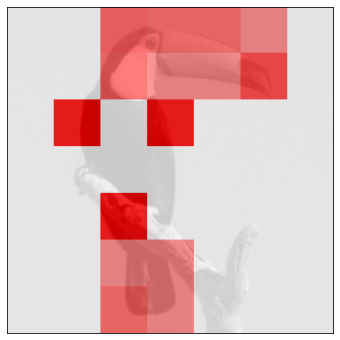

WHAT THE HUMANS AGREE ON S_score


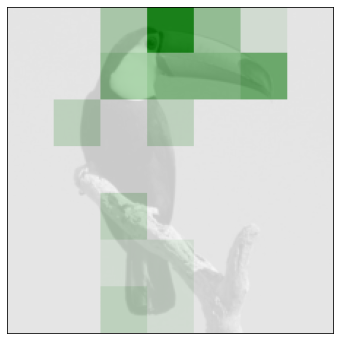

Mean of all standard deviations dim std_image 0.08
Mean of top 10% (5st) standard deviations 0.33
WHAT THE MODELS DISAGREE ON D_score


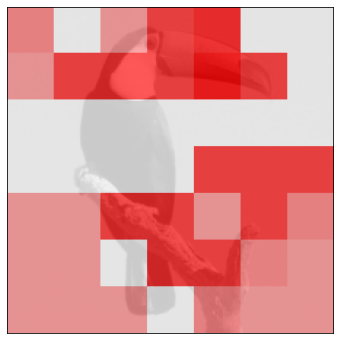

WHAT THE MODELS AGREE ON S_score


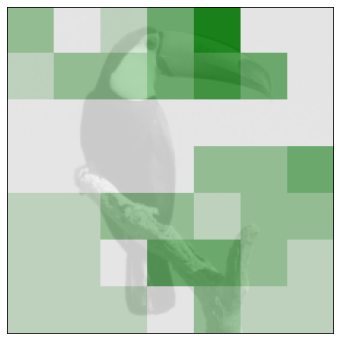

Mean of all standard deviations dim std_image 0.20
Mean of top 10% (5st) standard deviations 0.43
HUMAN MACHINE COMPARISON


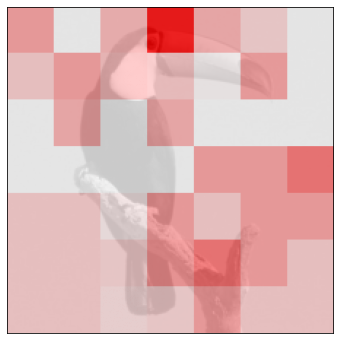

In [22]:
# Uncomment for the different images
# animal="dromedar"
# image_index = 0
# animal="gorilla"
# image_index = 1
animal="tucan"
image_index = 2
#Uncomment for the different teams
human_saliency_map="design-team"
#human_saliency_map="study"
#human_saliency_map="all" #Study and design together
save_path ='/content/ISMIS/human_saliency/'+animal+'/' 
save_path2 ='/content/ISMIS/human_machine/'+human_saliency_map+'/'+animal+'/'
saliency_map_human_aggregate = calc_S_score_D_score_Human("/content/human_saliency/"+animal+"/",human_saliency_map+".txt","/content/testshapes2/study1/",image_index,save_path)
saliency_map_machine_aggregate = calc_mean_std_machine_maps(image_index)
map = visualise_difference(saliency_map_human_aggregate[0],saliency_map_machine_aggregate[0],"/content/testshapes2/study1/",image_index,save_path2)